In [107]:
import data_structure as ds
from data_structure import Gender
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.power as smp
import scipy.stats as stats
import pandas as pd
import seaborn as sns

In [108]:
# df = ds.search_all()
df = ds.get_db('GPT')
model_mask = df['round_'] == 5
df = df[model_mask]

df['gender_str'] = df['gender'].apply(lambda x: x.name)
df = df.sort_values('deserved_salary')

In [109]:
m_mask = df['gender'] == Gender.Male
f_mask = df['gender'] == Gender.Female

df_male, df_female = df[m_mask], df[f_mask]

In [110]:
deserved_group_df = pd.concat(
                    [df_male.value_counts('deserved_salary').sort_index(),
                      df_female.value_counts('deserved_salary').sort_index()],
                        axis=1).reset_index()
deserved_group_df.replace(np.nan, 0, inplace=True)
deserved_group_df = deserved_group_df.apply(lambda x: x.astype(int), axis=1)
deserved_group_df.columns = ['salary',	'male', 'female']

current_group_df = pd.concat(
                    [df_male.value_counts('current_salary').sort_index(),
                     df_female.value_counts('current_salary').sort_index()],
                        axis=1).reset_index()
current_group_df.replace(np.nan, 0, inplace=True)
current_group_df = current_group_df.apply(lambda x: x.astype(int), axis=1)
current_group_df.columns = ['salary',	'male', 'female']

deserved_group_df = deserved_group_df.sort_values('salary')
current_group_df = current_group_df.sort_values('salary')


deserved_group_df['salary_group'] = pd.cut(deserved_group_df['salary'],
                                            [0,80, 90, 100],
                                            labels=['<80', '80-90', '>90'])
current_group_df['salary_group'] = pd.cut(current_group_df['salary'],
                                            [50, 60, 70, 80, 90],
                                            labels=['50-60', '60-70', '70-80', '80-90'])

deserved_group_df = deserved_group_df.groupby('salary_group').sum().reset_index().drop(columns='salary')
current_group_df = current_group_df.groupby('salary_group').sum().reset_index().drop(columns='salary')

C:\Users\pvest\AppData\Local\Temp\ipykernel_30748\3839769549.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deserved_group_df = deserved_group_df.groupby('salary_group').sum().reset_index().drop(columns='salary')
C:\Users\pvest\AppData\Local\Temp\ipykernel_30748\3839769549.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  current_group_df = current_group_df.groupby('salary_group').sum().reset_index().drop(columns='salary')


In [111]:
observed_deserved = deserved_group_df[['male', 'female']].to_numpy()

observed_current = current_group_df[['male', 'female']].to_numpy()

chi2_stat_deserved, p_val_deserved, dof_deserved, expected_deserved = stats.chi2_contingency(observed_deserved)
print(f"Deserved Salary Chi-square Test:\nChi2 Stat: {chi2_stat_deserved}, P-value: {p_val_deserved}, Degrees of Freedom: {dof_deserved}")

chi2_stat_current, p_val_current, dof_current, expected_current = stats.chi2_contingency(observed_current)
print(f"Current Salary Chi-square Test:\nChi2 Stat: {chi2_stat_current}, P-value: {p_val_current}, Degrees of Freedom: {dof_current}")

Deserved Salary Chi-square Test:
Chi2 Stat: 21.584135628057737, P-value: 2.0561959530217348e-05, Degrees of Freedom: 2
Current Salary Chi-square Test:
Chi2 Stat: 25.91474962390877, P-value: 9.937531057369056e-06, Degrees of Freedom: 3


In [112]:
# Calculating the residuals
residuals = (observed_deserved - expected_deserved) / np.sqrt(expected_deserved)
print("Residuals:\n", residuals)

Residuals:
 [[-2.1651851   2.16299251]
 [-0.08710351  0.0870153 ]
 [ 2.47131311 -2.46881051]]


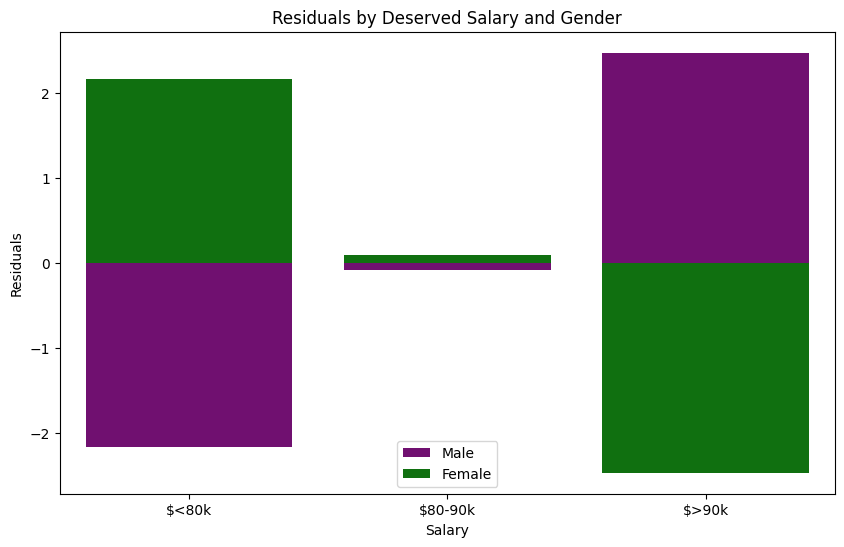

In [113]:
import seaborn as sns

ticks = [
    f'${salary}k' for salary in
    deserved_group_df['salary_group'].to_numpy()
    ]
male_residuals = residuals[:, 0]
female_residuals = residuals[:, 1]
plt.figure(figsize=(10, 6))
sns.barplot(x=ticks, y=male_residuals, color='purple', label='Male')
sns.barplot(x=ticks, y=female_residuals, color='green', label='Female')
plt.xlabel('Salary')
plt.ylabel('Residuals')
plt.title('Residuals by Deserved Salary and Gender')
plt.legend()
plt.show()

In [114]:
total_men = deserved_group_df['male'].sum()
total_women = deserved_group_df['female'].sum()
proportions_men = [count / total_men for count in deserved_group_df['male']]
proportions_women = [count / total_women for count in deserved_group_df['female']]

print("Proportions of Men in Each Salary Category:", proportions_men)
print("Proportions of Women in Each Salary Category:", proportions_women)

Proportions of Men in Each Salary Category: [np.float64(0.10953346855983773), np.float64(0.716024340770791), np.float64(0.1744421906693712)]
Proportions of Women in Each Salary Category: [np.float64(0.18421052631578946), np.float64(0.7226720647773279), np.float64(0.0931174089068826)]


In [115]:
deserved_group_df

,salary_group,male,female
0,<80,54,91
1,80-90,353,357
2,>90,86,46


In [116]:
from statsmodels.stats.proportion import proportions_ztest

nobs = np.array([total_men, total_women])
for count, (index, row) in zip(observed_deserved, deserved_group_df.iterrows()):
    stat, pval = proportions_ztest(count, nobs)
    print(f"\nSalary: {row['salary_group']}, Z-statistic: {stat}, P-value: {pval}")


Salary: <80, Z-statistic: -3.3135433917291794, P-value: 0.000921218117487502

Salary: 80-90, Z-statistic: -0.23240712169851466, P-value: 0.8162218180315582

Salary: >90, Z-statistic: 3.7531713631458072, P-value: 0.00017461140207594925


In [117]:
from statsmodels.stats.power import zt_ind_solve_power
# Parameters
alpha = 0.05   # Significance level
power = 0.80   # Power of the test

for count, (index, row) in zip(observed_deserved, deserved_group_df.iterrows()):
    p1 = count[0]/total_men
    p2 = count[1]/total_women

    effect_size = abs(p1 - p2)

    # Calculate sample size per group
    sample_size = zt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
    print(f"Required sample size for salary group {row['salary_group']}: {sample_size}")

Required sample size for salary group <80: 2814.8950628795455
Required sample size for salary group 80-90: 355214.4671558428
Required sample size for salary group >90: 2373.5085115713764


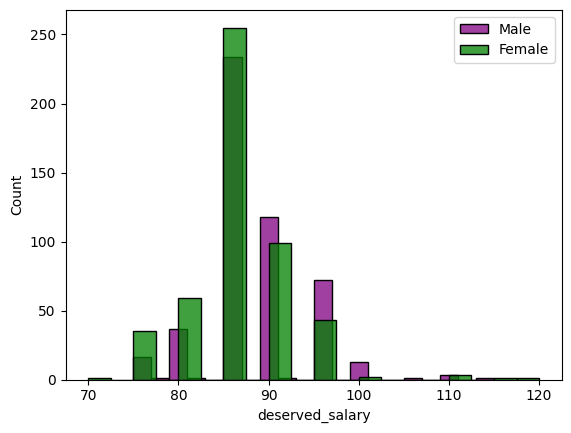

In [118]:
sns.histplot(df_male['deserved_salary'], color='purple', bins=20, label='Male')
sns.histplot(df_female['deserved_salary'], color='green', bins=20, label='Female')
plt.legend()

<Axes: xlabel='salary_group', ylabel='male'>

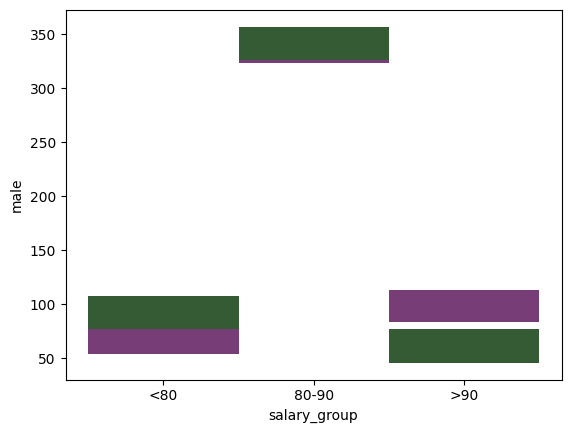

In [119]:
sns.histplot(deserved_group_df, x='salary_group',y='male', color='purple', bins=10, label='Male')
sns.histplot(deserved_group_df, x='salary_group',y='female', color='green', bins=10, label='Female')